In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:

train_dir = '/content/drive/MyDrive/Train_CE'
val_dir = '/content/drive/MyDrive/Val_CE'
test_dir = '/content/drive/MyDrive/Test_CE'

In [ ]:
import os
from PIL import Image
import numpy as np

def preprocess_images(input_dir, output_dir, target_size=(224, 224)):
    """
    Resizes and normalizes images to the range [0, 1].
    """
    os.makedirs(output_dir, exist_ok=True)

    for class_folder in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_folder)
        output_class_path = os.path.join(output_dir, class_folder)
        os.makedirs(output_class_path, exist_ok=True)

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            with Image.open(img_path) as img:
                # Resize image
                img = img.resize(target_size)

                # Convert to NumPy array and normalize
                img_array = np.array(img).astype('float32') / 255.0  # Scale pixel values to [0, 1]

                # Convert back to image for saving
                img = Image.fromarray((img_array * 255).astype('uint8'))

                # Save the preprocessed image
                img.save(os.path.join(output_class_path, img_name))

# Paths to datasets
train_dir = '/content/drive/MyDrive/Train_CE'
val_dir = '/content/drive/MyDrive/Val_CE'
test_dir = '/content/drive/MyDrive/Test_CE'

# Output paths for preprocessed datasets
preprocessed_train_dir = '/content/Preprocessed_Train_CE2'
preprocessed_val_dir = '/content/Preprocessed_Val_CE2'
preprocessed_test_dir = '/content/Preprocessed_Test_CE2'

# Preprocess training, validation, and test datasets
preprocess_images(train_dir, preprocessed_train_dir, target_size=(224, 224))
preprocess_images(val_dir, preprocessed_val_dir, target_size=(224, 224))
preprocess_images(test_dir, preprocessed_test_dir, target_size=(224, 224))

print("All datasets have been resized and normalized successfully.")


All datasets have been resized and normalized successfully.


Found 23165 images belonging to 21 classes.
Found 2317 images belonging to 21 classes.
Found 2322 images belonging to 21 classes.
Epoch 1/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.5558 - loss: 1.5432 - val_accuracy: 0.1998 - val_loss: 2.2832
Epoch 2/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step - accuracy: 0.6273 - loss: 1.2165 - val_accuracy: 0.2033 - val_loss: 2.0046
Epoch 3/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.6277 - loss: 1.2024 - val_accuracy: 0.1985 - val_loss: 2.1631
Epoch 4/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.6312 - loss: 1.1741 - val_accuracy: 0.2041 - val_loss: 1.9993
Epoch 5/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.6319 - loss: 1.1769 - val_accuracy: 0.2046 - val_loss: 2.0778
Epoch 6/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.6307 - loss: 1.1597 - val_accuracy: 0.2054 - val_loss: 2.0955
Epoch 7/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.6298 - loss: 1.1353 - 

Test Accuracy: 0.38


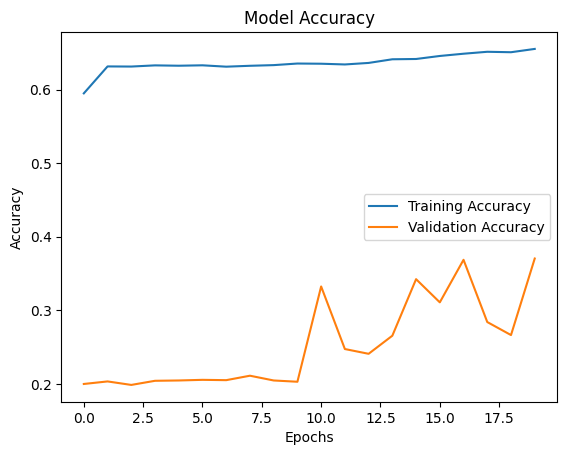

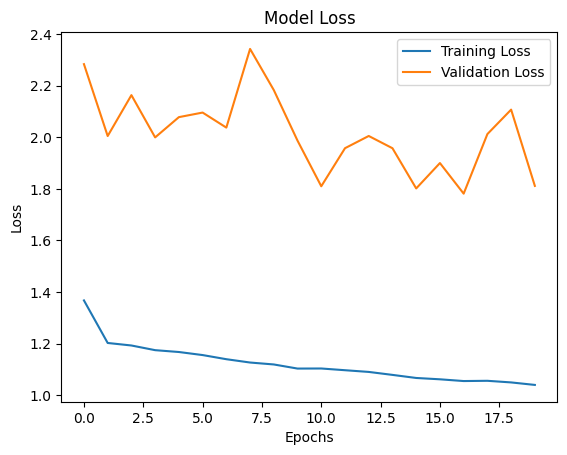

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Paths to preprocessed datasets
train_dir = '/content/Preprocessed_Train_CE2'
val_dir = '/content/Preprocessed_Val_CE2'
test_dir = '/content/Preprocessed_Test_CE2'

# Hyperparameters
batch_size = 32
img_size = (224, 224)
epochs = 20

# Data generators (rescale only, since preprocessing is already done)
data_gen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = data_gen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = data_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Final model
res50_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
res50_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Train the model
history = res50_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    verbose=1  # Prints the progress at each epoch
)

# Print training and validation accuracies at each epoch
for epoch in range(epochs):
    train_acc = history.history['accuracy'][epoch]
    val_acc = history.history['val_accuracy'][epoch]
    print(f"Epoch {epoch + 1}/{epochs}: Training Accuracy = {train_acc:.4f}, Validation Accuracy = {val_acc:.4f}")

# Evaluate the model on the test set
test_loss, test_accuracy = res50_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Save the trained model
res50_model.save('/content/res50_model.h5')

# Plot training history
# Accuracy plot
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import numpy as np
import tensorflow as tf

# Generate predictions for the test set
predictions = res50_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Compute AUC for each class
try:
    auc = roc_auc_score(
        tf.keras.utils.to_categorical(true_classes, num_classes=len(test_generator.class_indices)),
        predictions,
        multi_class='ovr'
    )
    print(f"AUC (macro-average): {auc:.4f}")
except ValueError as e:
    print(f"AUC could not be computed: {e}")

# Compute precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(
    true_classes, predicted_classes, average='weighted'
)
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1_score:.4f}")


73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
AUC could not be computed: Only one class present in y_true. ROC AUC score is not defined in that case.
Weighted Precision: 0.3702
Weighted Recall: 0.3786
Weighted F1-Score: 0.3342


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 23165 images belonging to 21 classes.
Found 2317 images belonging to 21 classes.
Found 2322 images belonging to 21 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


724/724 ━━━━━━━━━━━━━━━━━━━━ 88s 85ms/step - accuracy: 0.7139 - loss: 0.9131 - val_accuracy: 0.6444 - val_loss: 1.0551
Epoch 2/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step - accuracy: 0.8178 - loss: 0.5283 - val_accuracy: 0.6487 - val_loss: 1.0211
Epoch 3/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step - accuracy: 0.8388 - loss: 0.4621 - val_accuracy: 0.6698 - val_loss: 0.9301
Epoch 4/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step - accuracy: 0.8578 - loss: 0.4038 - val_accuracy: 0.6893 - val_loss: 0.9271
Epoch 5/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.8606 - loss: 0.3849 - val_accuracy: 0.7087 - val_loss: 0.8952
Epoch 6/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - accuracy: 0.8691 - loss: 0.3664 - val_accuracy: 0.7186 - val_loss: 0.7810
Epoch 7/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.8828 - loss: 0.3227 - val_accuracy: 0.7397 - val_loss: 0.7194
Epoch 8/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step - accuracy: 0.8890 - loss: 0.3033 - val_accurac

Test Accuracy: 0.74


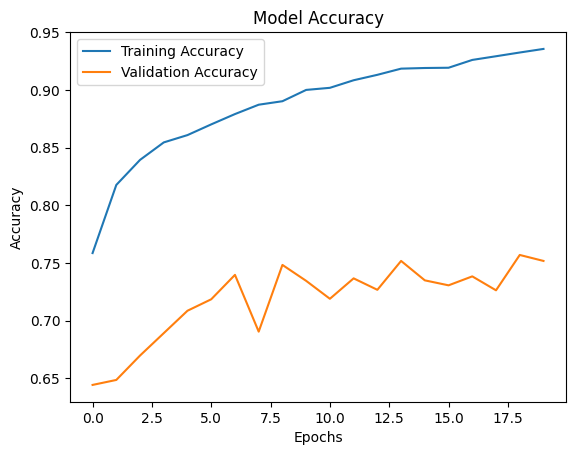

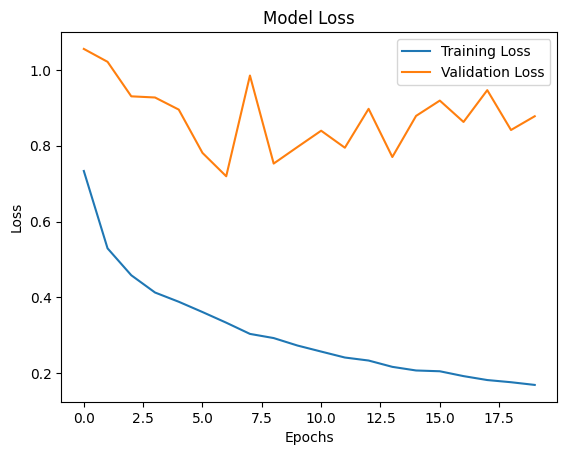

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Paths to preprocessed datasets
train_dir = '/content/Preprocessed_Train_CE2'
val_dir = '/content/Preprocessed_Val_CE2'
test_dir = '/content/Preprocessed_Test_CE2'

# Hyperparameters
batch_size = 32
img_size = (224, 224)
epochs = 20

# Data generators (rescale only, since preprocessing is already done)
data_gen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = data_gen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = data_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Final model
densenet121_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
densenet121_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

# Train the model
history = densenet121_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    verbose=1  # Prints the progress at each epoch
)

# Print training and validation accuracies at each epoch
for epoch in range(epochs):
    train_acc = history.history['accuracy'][epoch]
    val_acc = history.history['val_accuracy'][epoch]
    print(f"Epoch {epoch + 1}/{epochs}: Training Accuracy = {train_acc:.4f}, Validation Accuracy = {val_acc:.4f}")

# Evaluate the model on the test set
test_loss, test_accuracy = densenet121_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Save the trained model
densenet121_model.save('/content/densenet121_model.h5')

# Plot training history
# Accuracy plot
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import numpy as np
import tensorflow as tf

# Generate predictions for the test set
predictions = densenet121_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Compute AUC for each class
try:
    auc = roc_auc_score(
        tf.keras.utils.to_categorical(true_classes, num_classes=len(test_generator.class_indices)),
        predictions,
        multi_class='ovr'
    )
    print(f"AUC (macro-average): {auc:.4f}")
except ValueError as e:
    print(f"AUC could not be computed: {e}")

# Compute precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(
    true_classes, predicted_classes, average='weighted'
)
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1_score:.4f}")


73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step
AUC could not be computed: Only one class present in y_true. ROC AUC score is not defined in that case.
Weighted Precision: 0.1661
Weighted Recall: 0.1697
Weighted F1-Score: 0.1674


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 23165 images belonging to 21 classes.
Found 2317 images belonging to 21 classes.
Found 2322 images belonging to 21 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


724/724 ━━━━━━━━━━━━━━━━━━━━ 52s 58ms/step - accuracy: 0.7215 - loss: 0.8770 - val_accuracy: 0.6435 - val_loss: 1.0600
Epoch 2/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.8222 - loss: 0.5147 - val_accuracy: 0.6854 - val_loss: 0.8779
Epoch 3/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.8576 - loss: 0.4075 - val_accuracy: 0.6871 - val_loss: 0.9045
Epoch 4/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.8711 - loss: 0.3486 - val_accuracy: 0.6729 - val_loss: 0.9750
Epoch 5/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.8843 - loss: 0.3186 - val_accuracy: 0.6573 - val_loss: 1.0518
Epoch 6/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - accuracy: 0.8906 - loss: 0.2850 - val_accuracy: 0.7065 - val_loss: 0.9348
Epoch 7/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.9028 - loss: 0.2567 - val_accuracy: 0.6772 - val_loss: 1.0079
Epoch 8/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.9074 - loss: 0.2352 - val_accurac

Test Accuracy: 0.71


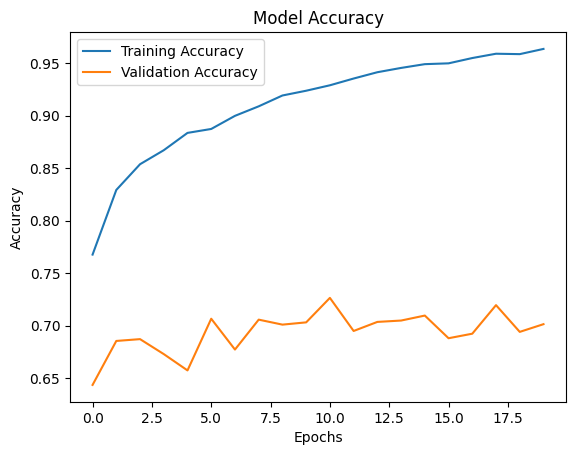

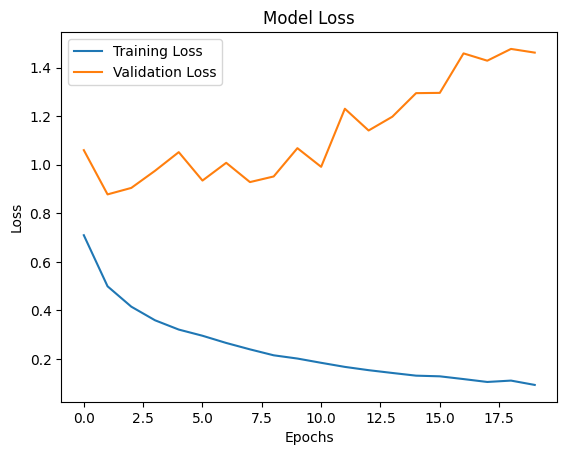

73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step
AUC could not be computed: Only one class present in y_true. ROC AUC score is not defined in that case.
Weighted Precision: 0.7418
Weighted Recall: 0.7054
Weighted F1-Score: 0.7191


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import numpy as np

# Paths to preprocessed datasets
train_dir = '/content/Preprocessed_Train_CE2'
val_dir = '/content/Preprocessed_Val_CE2'
test_dir = '/content/Preprocessed_Test_CE2'

# Hyperparameters
batch_size = 32
img_size = (224, 224)
epochs = 20

# Data generators
data_gen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = data_gen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = data_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Final model
xception_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
xception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Train the model
history = xception_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = xception_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Save the trained model
xception_model.save('/content/xception_model.h5')

# Plot training history
# Accuracy plot
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Metrics: AUC, Precision, Recall, F1-Score
predictions = xception_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Compute AUC
try:
    auc = roc_auc_score(
        tf.keras.utils.to_categorical(true_classes, num_classes=len(test_generator.class_indices)),
        predictions,
        multi_class='ovr'
    )
    print(f"AUC (macro-average): {auc:.4f}")
except ValueError as e:
    print(f"AUC could not be computed: {e}")

# Compute Precision, Recall, F1-Score
precision, recall, f1_score, _ = precision_recall_fscore_support(
    true_classes, predicted_classes, average='weighted'
)
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1_score:.4f}")


Found 23165 images belonging to 21 classes.
Found 2317 images belonging to 21 classes.
Found 2322 images belonging to 21 classes.
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


724/724 ━━━━━━━━━━━━━━━━━━━━ 61s 65ms/step - accuracy: 0.5875 - loss: 1.4229 - val_accuracy: 0.2024 - val_loss: 2.0441
Epoch 2/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.6277 - loss: 1.2081 - val_accuracy: 0.2072 - val_loss: 2.5802
Epoch 3/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.6333 - loss: 1.1862 - val_accuracy: 0.2106 - val_loss: 1.9585
Epoch 4/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.6297 - loss: 1.1790 - val_accuracy: 0.2046 - val_loss: 2.0863
Epoch 5/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.6367 - loss: 1.1480 - val_accuracy: 0.2106 - val_loss: 2.0866
Epoch 6/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.6311 - loss: 1.1485 - val_accuracy: 0.2093 - val_loss: 1.9481
Epoch 7/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - accuracy: 0.6332 - loss: 1.1441 - val_accuracy: 0.2110 - val_loss: 1.9666
Epoch 8/20
724/724 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.6367 - loss: 1.1268 - val_accurac

Test Accuracy: 0.34


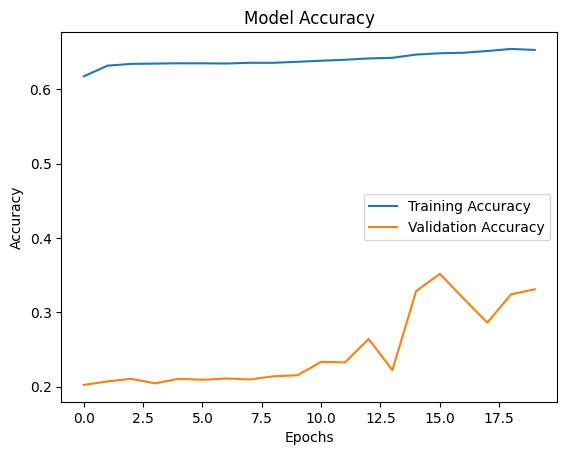

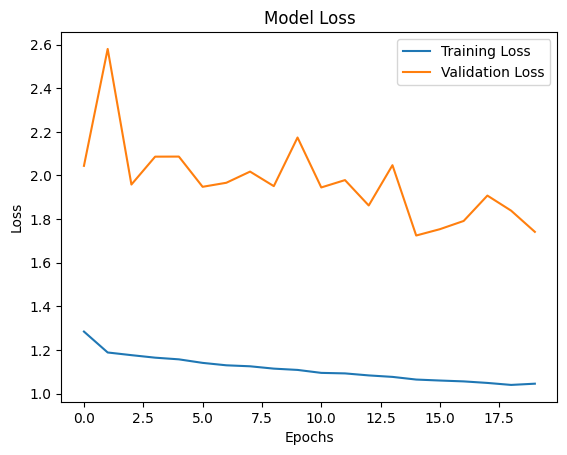

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step
AUC could not be computed: Only one class present in y_true. ROC AUC score is not defined in that case.
Weighted Precision: 0.4530
Weighted Recall: 0.3450
Weighted F1-Score: 0.3272


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import numpy as np

# Paths to preprocessed datasets
train_dir = '/content/Preprocessed_Train_CE2'
val_dir = '/content/Preprocessed_Val_CE2'
test_dir = '/content/Preprocessed_Test_CE2'

# Hyperparameters
batch_size = 32
img_size = (224, 224)
epochs = 20

# Data generators
data_gen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = data_gen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = data_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the MobileNetV3 Large model
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Final model
mobilenetv3_large_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
mobilenetv3_large_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

# Train the model
history = mobilenetv3_large_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = mobilenetv3_large_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Save the trained model
mobilenetv3_large_model.save('/content/mobilenetv3_large_model.h5')

# Plot training history
# Accuracy plot
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Metrics: AUC, Precision, Recall, F1-Score
predictions = mobilenetv3_large_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Compute AUC
try:
    auc = roc_auc_score(
        tf.keras.utils.to_categorical(true_classes, num_classes=len(test_generator.class_indices)),
        predictions,
        multi_class='ovr'
    )
    print(f"AUC (macro-average): {auc:.4f}")
except ValueError as e:
    print(f"AUC could not be computed: {e}")

# Compute Precision, Recall, F1-Score
precision, recall, f1_score, _ = precision_recall_fscore_support(
    true_classes, predicted_classes, average='weighted'
)
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1_score:.4f}")
